> Copyright 2023, MASSACHUSETTS INSTITUTE OF TECHNOLOGY<br/>
> Subject to FAR 52.227-11 – Patent Rights – Ownership by the Contractor (May 2014).<br/>
> SPDX-License-Identifier: MIT

# Torchvision Object Detection Example

The MAITE library provides interfaces for AI components such as datasets, models, metrics, and augmentations to make their use more consistent across test and evaluation (T&E) tools and workflows.

In this tutorial, you will use MAITE in conjunction with a set of common libraries to:
* Wrap an object detection dataset from Torchvision (COCO),
* Wrap an object detection model from Torchvision (Faster RCNN),
* Wrap a metric from Torchmetrics (mean average precision),
* Compute performance on the clean dataset using MAITE's `evaluate` workflow utility,
* Wrap an augmenation from Kornia (Gaussian noise), and
* Compute performance on the perturbed dataset using `evaluate`.

Once complete, you will have a basic understanding of MAITE’s interfaces for datasets, models, metric, and augmentations, as well as how to use MAITE’s native API for running evaluations.

This tutorial does not assume any prior knowledge, but some experience with Python, machine learning, and the PyTorch framework may be helpful. Portions of code are adapted from the object detection example in the Torchvision [documentation](https://pytorch.org/vision/stable/models.html#object-detection).

Note: This tutorial can be found as a Jupyter notebook [here](https://github.com/mit-ll-ai-technology/maite/blob/main/examples/torchvision_object_detection/torchvision_object_detection.ipynb).

## Getting Started

This tutorial uses MAITE, PyTorch, Torchvision, Torchmetrics, Kornia, and Matplotlib. You can use the following commands to create a conda environment with these dependencies:

```
conda create --name torchvision_obj_det python=3.10
conda activate torchvision_obj_det
pip install maite jupyter torch torchvision torchmetrics pycocotools kornia
```

Note that the notebook was tested with these exact versions:

```
pip install maite jupyter==1.0.0 torch==2.2.1 torchvision==0.17.1 torchmetrics==1.3.2 pycocotools==2.0.7 kornia==0.7.2
```

Now that we've created an environment, we import the necessary libraries:

In [1]:
from __future__ import annotations

import json
import kornia.augmentation as K
import matplotlib.pyplot as plt
import requests
import torch
import numpy as np

from dataclasses import dataclass
from pathlib import Path
from PIL import Image
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision.datasets import CocoDetection
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.ops.boxes import box_convert
from torchvision.transforms.functional import to_pil_image, pil_to_tensor
from torchvision.utils import draw_bounding_boxes
from typing import Any, Callable, Sequence

import maite.protocols.object_detection as od

from maite.protocols import ArrayLike
from maite.workflows import evaluate

/Users/je24578/miniconda3/envs/maite_dev/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Wrapping a Torchvision Dataset

We'll be wrapping Torchvision's [`CocoDetection`](https://pytorch.org/vision/stable/generated/torchvision.datasets.CocoDetection.html#torchvision.datasets.CocoDetection) dataset, which provides support for the COCO object detection dataset.

In order to make this tutorial faster to run and not require a large download, we've provided a modified annotations JSON file from the validation split of the COCO 2017 Object Detection Task containing only the first 4 images (and will dynamically download only those images using the "coco_url").

Note that the COCO annotations are licensed under a [Creative Commons Attribution 4.0 License](https://creativecommons.org/licenses/by/4.0/legalcode) (see COCO [terms of use](https://cocodataset.org/#termsofuse)).

### Native Dataset

First we download the first 4 images of the validation split:

In [2]:
def download_images(coco_json_subset: dict[str, Any], root: str | Path):
    root = Path(root)
    root.mkdir(parents=True, exist_ok=True)

    for image in coco_json_subset["images"]:
        url = image["coco_url"]
        filename = Path(root) / image["file_name"]
        if filename.exists():
            print(f"skipping {url}")
        else:
            print(f"saving {url} to {filename} ... ", end="")
            r = requests.get(url)
            with open(filename, "wb") as f:
                f.write(r.content)
            print(f"done")

COCO_ROOT = Path("coco_val2017_subset")
ann_subset_file = COCO_ROOT / "instances_val2017_first4.json"
coco_subset_json = json.load(open(ann_subset_file, "r"))

download_images(coco_subset_json, root=COCO_ROOT)

skipping http://images.cocodataset.org/val2017/000000397133.jpg
skipping http://images.cocodataset.org/val2017/000000037777.jpg
skipping http://images.cocodataset.org/val2017/000000252219.jpg
skipping http://images.cocodataset.org/val2017/000000087038.jpg


Next we create the Torchvision dataset and verify that its reduced length is 4:

In [3]:
tv_dataset = CocoDetection(
    root="coco_val2017_subset",
    annFile="coco_val2017_subset/instances_val2017_first4.json"
)

print(f"\n{len(tv_dataset) = }")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

len(tv_dataset) = 4


Each item of the dataset contains an image along with a list of annotation dictionaries. The bounding box (`bbox`) format is "xywh" and the `category_id` is one of COCO's 90 categories (each of which has a name and a supercategory).

In [4]:
# Get first image and its annotations
img, annotations = tv_dataset[0]

# Explore structure
print(f"{type(img) = }")
print(f"{type(annotations) = }")
print(f"{type(annotations[0]) = }")
print(f"{len(annotations[0]) = }")
print(f"{annotations[0].keys() = }")
print(f"{annotations[0]['bbox'] = }")
print(f"{annotations[0]['category_id'] = }")
print(f"{tv_dataset.coco.cats[64] = }")

type(img) = <class 'PIL.Image.Image'>
type(annotations) = <class 'list'>
type(annotations[0]) = <class 'dict'>
len(annotations[0]) = 7
annotations[0].keys() = dict_keys(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id'])
annotations[0]['bbox'] = [102.49, 118.47, 7.9, 17.31]
annotations[0]['category_id'] = 64
tv_dataset.coco.cats[64] = {'supercategory': 'furniture', 'id': 64, 'name': 'potted plant'}


### Wrapped Dataset

In order to facilitate executing T&E workflows with datasets from difference sources (e.g., existing libraries like Torchvision or Hugging Face or custom datasets), MAITE provides a `Dataset` protocol that specifies the expected interface (i.e, a minimal set of required attributes, methods, and method type signatures).

At a high level, a MAITE object detection `Dataset` needs to have two methods (`__len__` and `__getitem__`) and return the image, target (label/class), and metadata associated with a requested dataset index.

The following wrapper internally converts from the "native" format of the dataset to types compatible with MAITE:

In [5]:
@dataclass
class CocoDetectionTarget:
    boxes: torch.Tensor
    labels: torch.Tensor
    scores: torch.Tensor
    
class MaiteCocoDetection:
    def __init__(self, dataset: CocoDetection):
        self._dataset = dataset

    def __len__(self) -> int:
        return len(self._dataset)

    def __getitem__(self, index: int) -> tuple[ArrayLike, CocoDetectionTarget, dict[str, Any]]:
        assert index < len(self._dataset)

        # get original data item
        img_pil, annotations = self._dataset[index]

        # format input
        img_pt = pil_to_tensor(img_pil)

        # format ground truth
        num_boxes = len(annotations)
        boxes = torch.zeros(num_boxes, 4)
        for i, ann in enumerate(annotations):
            bbox = torch.as_tensor(ann["bbox"])
            boxes[i,:] = box_convert(bbox, in_fmt="xywh", out_fmt="xyxy")
        
        labels = torch.as_tensor([ann["category_id"] for ann in annotations])
        scores = torch.ones(num_boxes)

        # format metadata
        metadata = {
            "id": self._dataset.ids[index]
        }

        return img_pt, CocoDetectionTarget(boxes, labels, scores), metadata

We now create a wrapped version of the dataset that conforms to the MAITE protocol.

Note that the `dataset` variable has `od.Dataset` as the type hint. If your environment has a static type checker enabled (e.g., the Pyright type checker via the Pylance language server in VS Code), then the type checker will verify that our wrapped dataset conforms to the protocol and indicate a problem if not (e.g., by underlining with a red squiggle).

In [6]:
dataset: od.Dataset = MaiteCocoDetection(tv_dataset)
len(dataset)

4

Next we'll display a sample image along with the ground truth annotations.

In [7]:
def create_pil_image(
    input: ArrayLike,
    target: od.ObjectDetectionTarget,
    id2name: dict[int, str],
    color: str = "red"
) -> Image.Image:
    img_pt = torch.as_tensor(input)
    boxes = torch.as_tensor(target.boxes)
    label_ids = torch.as_tensor(target.labels)
    label_names = [id2name[int(id.item())] for id in label_ids]
    box = draw_bounding_boxes(img_pt, boxes=boxes, labels=label_names, colors=color, width=2)
    return to_pil_image(box.detach()) 

In [8]:
# Get mapping from COCO category to name
id2name = {k: v["name"] for k, v in tv_dataset.coco.cats.items()}

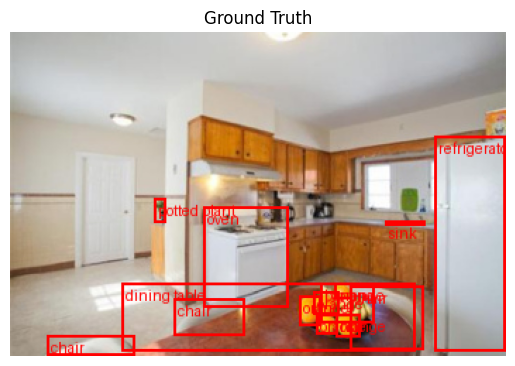

In [9]:
# Get sample image and overlay ground truth annotations (bounding boxes)
i = 0
input, target, _ = dataset[i]
img = create_pil_image(input, target, id2name)

fig, ax = plt.subplots()
ax.axis("off")
ax.set_title("Ground Truth")
ax.imshow(img);

## Wrapping a Torchvision Model

In this section, we'll wrap a Torchvision object detection model that's been pretrained on the COCO dataset.

First we create the "native" Torchvision model with a specified set of pretrained weights:

In [10]:
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
tv_model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.9)

Next we wrap the model to conform to the MAITE `od.Model` protocol, which requires a `__call__` method that takes a batch of inputs and returns a batch of predictions:

In [11]:
class TorchvisionDetector:
    def __init__(self, model: torch.nn.Module, transforms: Any, device: str):
        self.model = model
        self.transforms = transforms
        self.device = device

        self.model.eval()
        self.model.to(device)

    def __call__(self, batch: Sequence[ArrayLike]) -> Sequence[CocoDetectionTarget]:
        # tensor bridging
        batch_tn = torch.as_tensor(np.stack(batch, axis=0))
        assert batch_tn.ndim == 4

        # put on device
        batch_tn = batch_tn.to(self.device)

        # convert to list of tensors and apply inference transforms
        # - https://pytorch.org/vision/stable/models.html
        # - "The models expect a list of Tensor[C, H, W]."
        tv_input = [self.transforms(batch[i]) for i in range(len(batch))]

        # get predictions
        tv_predictions = self.model(tv_input)

        # reformat output
        predictions = [
            CocoDetectionTarget(
                p["boxes"].detach().cpu(),
                p["labels"].detach().cpu(),
                p["scores"].detach().cpu()
            )
            for p in tv_predictions
        ]

        return predictions

In [12]:
model: od.Model = TorchvisionDetector(
    model=tv_model,
    transforms=weights.transforms(),
    device="cpu"
)

For an initial test, we'll manually create an input batch and perform inference on it with the wrapped model:

xb.shape = torch.Size([1, 3, 230, 352])


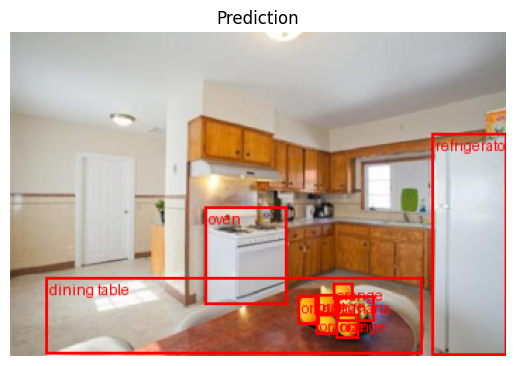

In [13]:
# Create batch with sample image
i = 0
x, y, md = dataset[i]
x = torch.as_tensor(x)
xb, yb, mdb = x.unsqueeze(0), [y], [md]
print(f"{xb.shape = }")

# Get predictions for batch(which just has one image for this example)
preds = model([xb[0]])

# Overlay detections on image
img = create_pil_image(xb[0], preds[0], id2name)

# Plot
fig, ax = plt.subplots()
ax.axis("off")
ax.set_title("Prediction")
ax.imshow(img)

Qualitatively, it appears that the model has detected the majority of the objects, but not all.

At this point, we'd like to perform a more quantitative evaluation across a larger set of images.

## Metrics

In this section we wrap a Torchmetrics object detection metric to conform to the MAITE `od.Metric` protocol.

First we create a "native" Torchmetrics mean average prediction (mAP) metric:

In [14]:
tm_metric = MeanAveragePrecision(
    box_format="xyxy",
    iou_type="bbox",
    iou_thresholds=[0.5],
    rec_thresholds=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    max_detection_thresholds=[1, 10, 100],
    class_metrics=False,
    extended_summary=False,
    average="macro"
)

Next we wrap the metric as a MAITE `od.Metric` that has the required `update`, `compute`, and `reset` methods:

In [15]:
class WrappedTorchmetricsMetric:
    def __init__(
        self,
        tm_metric: Callable[
            [list[dict[str, torch.Tensor]], list[dict[str, torch.Tensor]]], dict[str, Any]]
    ):
        self._tm_metric = tm_metric

    # Create utility function to convert ObjectDetectionTarget_impl type to what
    # the type expected by torchmetrics IntersectionOverUnion metric
    @staticmethod
    def to_tensor_dict(target: od.ObjectDetectionTarget) -> dict[str, torch.Tensor]:
        """
        Convert an ObjectDetectionTarget_impl into a dictionary expected internally by
        raw `update` method of raw torchmetrics method
        """
        out = {
            "boxes": torch.as_tensor(target.boxes),
            "scores": torch.as_tensor(target.scores),
            "labels": torch.as_tensor(target.labels),
        }

        return out

    def update(self, preds: od.TargetBatchType, targets: od.TargetBatchType) -> None:
        # Convert to natively-typed from of preds/targets
        preds_tm = [self.to_tensor_dict(pred) for pred in preds]
        targets_tm = [self.to_tensor_dict(tgt) for tgt in targets]
        self._tm_metric.update(preds_tm, targets_tm)

    def compute(self) -> dict[str, Any]:
        return self._tm_metric.compute()

    def reset(self) -> None:
        self._tm_metric.reset()

In [16]:
mAP_metric: od.Metric = WrappedTorchmetricsMetric(tm_metric)

## Workflows

Now we'll run MAITE's `evaluate` workflow, which manages the process of applying the model to the dataset (performing inference) and computing the desired metric.

In [17]:
# Run evaluate over original (clean) dataset
results, _, _ = evaluate(
    model=model,
    dataset=dataset,
    metric=mAP_metric
)

# Report mAP_50 performance
results["map_50"]

tensor(0.3713)

## Augmentations

The `evaluate` workflow takes an optional augmentation to allow measuring performance on a perturbed (degraded) version of the dataset. This is useful for evaluating the robustness of a model to a natural perturbation like noise.

In this section we'll wrap an augmentation from the Kornia library and re-run the evaluation.

First we create the "native" Kornia augmentation:

In [18]:
kornia_noise = K.RandomGaussianNoise(
    mean=0.0,
    std=0.08, # relative to [0, 1] pixel values
    p=1.0,
    keepdim=True
)

Next we wrap it as a MAITE `od.Augmentation`, with a `__call__` method that operations on batches:

In [19]:
class WrappedKorniaAugmentation:
    def __init__(self, kornia_aug: Any):
        self.kornia_aug = kornia_aug

    def __call__(
        self,
        batch: tuple[od.InputBatchType, od.TargetBatchType, od.DatumMetadataBatchType],
    ) -> tuple[od.InputBatchType, od.TargetBatchType, od.DatumMetadataBatchType]:
        # Unpack tuple
        xb, yb, metadata = batch

        # Type narrow / bridge input batch to PyTorch tensor
        xb_pt = [torch.as_tensor(xb_i) for xb_i in xb]
        assert xb_pt[0].ndim == 3, 'Input should be sequence of 3d ArrayLikes'

        # Apply augmentation to batch
        # Return augmentation outputs as uint8
        # - NOTE: assumes input batch has pixels in [0, 255]
        xb_aug = [(self.kornia_aug(xb_pti / 255.0).clamp(min=0.0, max=1.0) * 255.0).to(torch.uint8) for xb_pti in xb_pt]

        # Return augmented inputs and pass through unchanged targets and metadata
        return xb_aug, yb, metadata

In [20]:
noise: od.Augmentation = WrappedKorniaAugmentation(kornia_noise)

For an initial test, we manually create an input batch and perturb it with the wrapped augmentation:

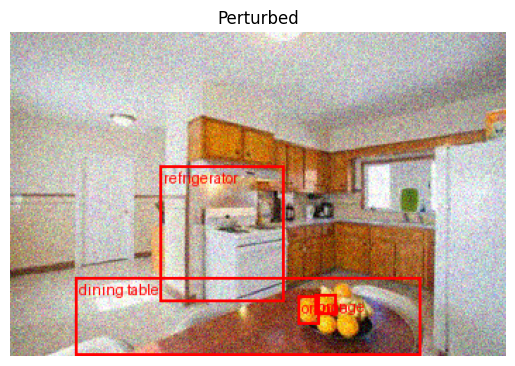

In [21]:
# Create batch with sample image
i = 0
x, y, md = dataset[i]
x = torch.as_tensor(x)
xb, yb, mdb = [x], [y], [md]

# Apply augmentation
xb_aug, yb_aug, mdb_aug = noise((xb, yb, mdb))

# Get predictions for augmented batch (which just has one image for this example)
preds_aug = model(xb_aug)

# Overlay detections on image
xb_aug = torch.as_tensor(xb_aug[0])
img_aug = create_pil_image(xb_aug, preds_aug[0], id2name)

# Show result
fig, ax = plt.subplots()
ax.axis("off")
ax.set_title("Perturbed")
ax.imshow(img_aug)

We see that the noise has resulted in some errors.

Finally, we run `evaluate` with the augmentation over the dataset:

In [22]:
# Run evaluate over perturbed dataset
results, _, _ = evaluate(
    model=model,
    dataset=dataset,
    metric=mAP_metric,
    augmentation=noise,
)

# Report mAP_50 performance
results["map_50"]

tensor(0.1948)

We see that the mAP_50 performance has decreased due to the simulated image degradation.

Congrats! You have now successfully used MAITE to wrap a dataset, model, metric, and augmentation from various libraries, and run an evaluation to compute the performance of the pretrained model on both clean and perturbed versions of the COCO validation subset.